In [77]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt

In [78]:
# Covariance matrix parameters

length_scale = 2/3
variance = 1.0

In [79]:
# Sample points for prediction
X = np.linspace(-10, 10, 100).reshape(-1, 1)  # 100 points from -5 to 5

# Observed data points
X_train = np.linspace(-10, 10, 10).reshape(-1, 1)  # 10 training points
y_train = np.sin(X_train).flatten()  # Example function values at training points

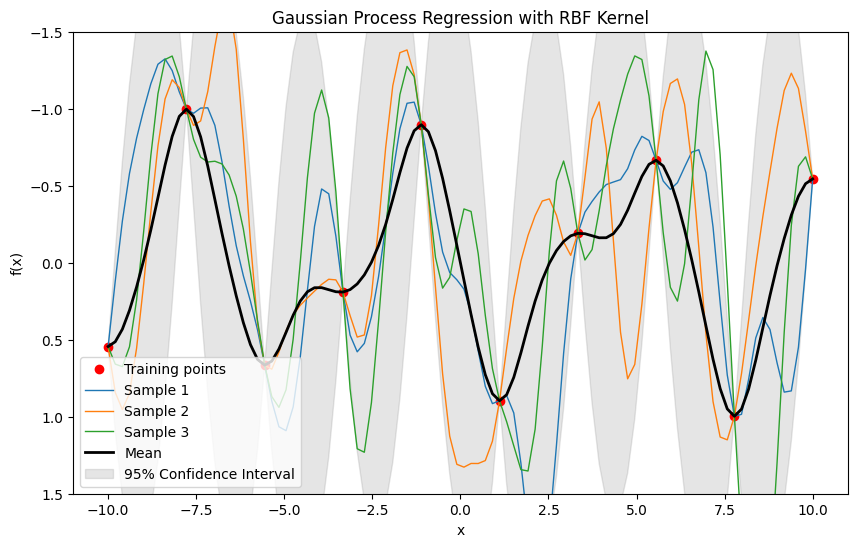

In [80]:
# GAUSSIAN PROCESS EXAMPLE 

# RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    sqdist = np.sum((x1 - x2)**2)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

# Covariance matrix for the training points
K = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        K[i, j] = rbf_kernel(X_train[i], X_train[j], length_scale, variance)

# Covariance matrix between the training points and the test points
K_s = np.zeros((len(X_train), len(X)))
for i in range(len(X_train)):
    for j in range(len(X)):
        K_s[i, j] = rbf_kernel(X_train[i], X[j], length_scale, variance)

# Covariance matrix for the test points
K_ss = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        K_ss[i, j] = rbf_kernel(X[i], X[j], length_scale, variance)

# Mean and covariance of the conditional distribution
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(X_train)))  # Add a small noise term for numerical stability

# Mean of the conditioned GP
mu_s = K_s.T.dot(K_inv).dot(y_train)

# Covariance of the conditioned GP
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Samples from the conditioned GP
np.random.seed(42)
samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=1)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Gaussian Process Regression with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((1.5, -1.5))
plt.legend()
plt.show()


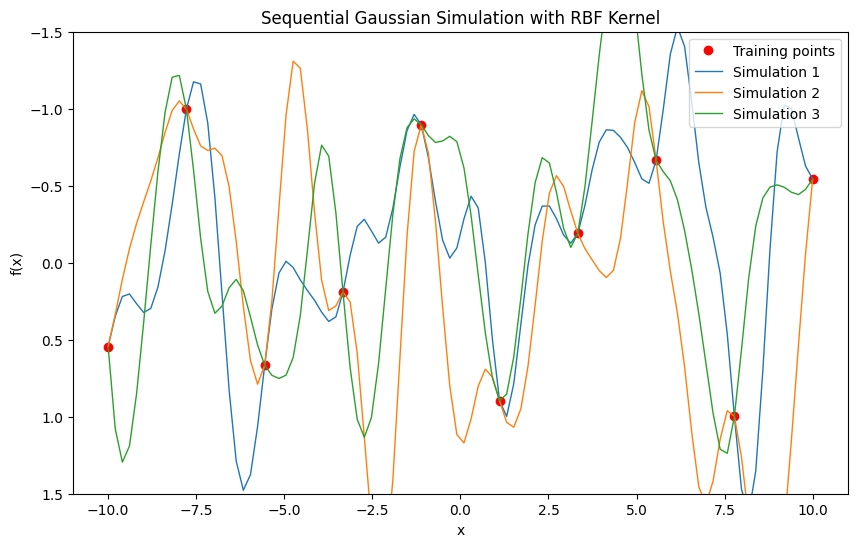

In [81]:
# SEQUENTIAL GAUSSIAN SIMULATION

# RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    sqdist = np.sum((x1 - x2)**2)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

# Function to perform SGS
def sequential_gaussian_simulation(X_train, y_train, X, kernel, length_scale, variance, num_simulations):
    simulations = np.zeros((num_simulations, len(X)))
    for s in range(num_simulations):
        y_sim = np.zeros(len(X))
        for i, xi in enumerate(X):
            X_all = np.vstack([X_train, X[:i+1]])
            K = np.zeros((len(X_all), len(X_all)))
            for m in range(len(X_all)):
                for n in range(len(X_all)):
                    K[m, n] = kernel(X_all[m], X_all[n], length_scale, variance)
            
            K_train = K[:len(X_train) + i, :len(X_train) + i]
            K_train_inv = np.linalg.inv(K_train + 1e-8 * np.eye(len(K_train)))
            
            K_s = K[:len(X_train) + i, len(X_train) + i:len(X_train) + i + 1]
            K_ss = K[len(X_train) + i:len(X_train) + i + 1, len(X_train) + i:len(X_train) + i + 1]
            
            mu = K_s.T.dot(K_train_inv).dot(np.append(y_train, y_sim[:i]))
            sigma = K_ss - K_s.T.dot(K_train_inv).dot(K_s)
            
            y_sim[i] = np.random.normal(mu, np.sqrt(sigma))
        
        simulations[s, :] = y_sim
    return simulations

# Perform SGS
num_simulations = 3
simulations = sequential_gaussian_simulation(X_train, y_train, X, rbf_kernel, length_scale, variance, num_simulations)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=1)
plt.title('Sequential Gaussian Simulation with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((1.5, -1.5))
plt.legend()
plt.show()


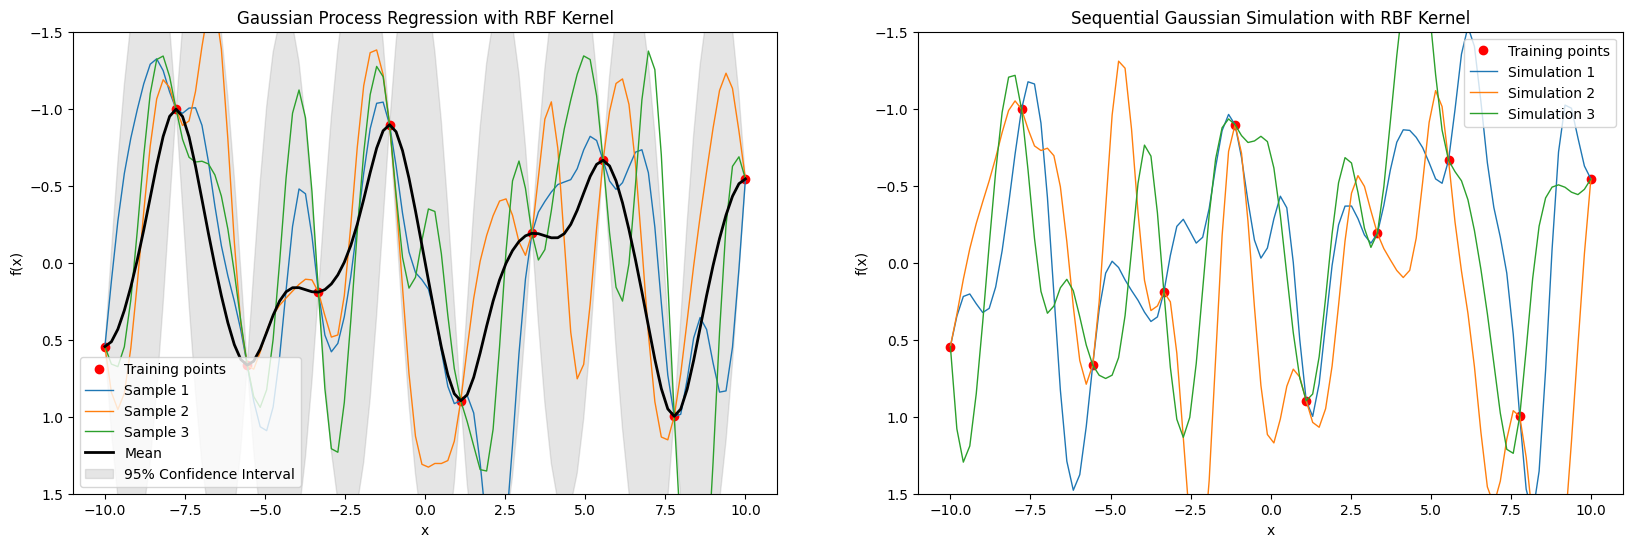

In [82]:
# PLOT GP AND SGS COMPARISON

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=1)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Gaussian Process Regression with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((1.5, -1.5))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=1)
plt.title('Sequential Gaussian Simulation with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((1.5, -1.5))
plt.legend()

plt.show()
